# A/B-тест и проверка гипотез по увеличению выручки интернет-магазина

## Содержание


- [**Шаг 1. Общая информация о данных**](#part_1)
    - [1.1. Введение в проект](#101)
    - [1.2. Описание данных](#102)
    - [1.3. Выводы из общей информации о данных](#103)


- [**Шаг 2. Приоритезация гипотез**](#part_2)
    - [2.1. Выводы из приоритезации гипотез](#201)


- [**Шаг 3. Анализ A/B-теста**](#part_3)
    - [3.1. Кумулятивная выручка по группам](#301)
    - [3.2. Кумулятивный средний чек по группам](#302)
    - [3.3. Кумулятивная конверсия по группам](#303)
    - [3.4. Граница для определения анормальных пользователей](#304)
    - [3.5. Проверка статистической значимости различий между группами по «сырым» данным](#305)
    - [3.6. Проверка статистической значимости различий между группами по «очищенным» данным](#306)
    - [3.7. Выводы из анализа A/B-теста](#307)

<a id='part_1'></a>
## Шаг 1. Общая информация о данных

<a id='101'></a>
### Введение в проект

Маркетинговый отдел крупного интернет-магазина подготовил список гипотез для увеличения выручки. Нужно приоритезировать гипотезы, запустить A/B-тест и обработать его результаты, чтобы оценить необходимость улучшения магазина.

<a id='102'></a>
### Описание данных

Таблица `hypothesis`:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

Таблица `orders`:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Таблица `visitors`:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# глобальные настройки отображения графиков
sns.mpl.rc('figure', figsize=(15, 9)) # размер графиков
sns.mpl.rc('axes', grid=False) # отключение фоновой сетки
sns.set_palette('coolwarm') # установка цветовой схемы
sns.mpl.rc('axes.spines', top=False, right=False) # скрытие рамки вокруг диаграмм

contrast_color = '#909090'
plt.rcParams.update({
    'figure.facecolor': (1.0, 0.0, 0.0, 0), 
    'axes.facecolor': (0.0, 1.0, 0.0, 0), 
    'savefig.facecolor': (0.0, 0.0, 1.0, 0), 
    'legend.framealpha': 0.0, 
    'text.color': contrast_color,
    'axes.labelcolor': contrast_color, 
    'xtick.color': contrast_color, 
    'ytick.color': contrast_color, 
    'axes.edgecolor': contrast_color
})

In [3]:
# чтение файлов с данными
original_hypothesis = pd.read_csv('./datasets/hypothesis.csv')
original_orders = pd.read_csv('./datasets/orders.csv', parse_dates=['date'])
original_visitors = pd.read_csv('./datasets/visitors.csv', parse_dates=['date'])

# создание рабочих копий файлов с данными
hypothesis = original_hypothesis.copy()
orders = original_orders.copy()
visitors = original_visitors.copy()

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

hypothesis.info()
hypothesis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


В `hypothesis` собраны 9 гипотез и 4 показателя, по которым оценили гипотезы по 10-балльной шкале. Названия столбцов переведены в нижний регистр для удобства.

In [5]:
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


В `orders` — лог всех транзакций за время проведения эксперимента — в течение августа 2019. Каждая запись соотнесена с той группой, к которой принадлежал пользователь. Сразу переименовали столбцы для удобства.

In [6]:
visitors.info()
visitors.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


В `visitors` — агрегированные по дням данные о посещаемости сайта во время эксперимента для каждой группы.

In [7]:
print('Полных дубликатов в orders:', orders.duplicated().sum())
print('Полных дубликатов в visitors:', visitors.duplicated().sum())

Полных дубликатов в orders: 0
Полных дубликатов в visitors: 0


<a id='103'></a>
### Выводы из общей информации о данных

1. Данные соответствуют описанию.
1. В данных нет дублированных строк или категорий, пропусков, нелогичных значений.
1. Типы данных соответствуют признакам.
1. В `orders` возможны выбросы в данных о выручке — проверим это во время анализа A/B-теста.

<a id='part_2'></a>
## Шаг 2. Приоритезация гипотез

Сейчас для тестирования нам доступны 9 гипотез. Каждая из них оценена по 10-балльной шкале по следующим показателям:
- **Impact** — влияние на пользователей того изменения, которое мы хотим внести; 
- **Confidence** — уверенность в том, что изменение повлияет именно так, как мы планируем; 
- **Efforts** - усилия для проверки гипотезы, сколько это будет нам стоить; 
- **Reach** - охват пользователей, которых затронет изменение.

Применим фреймворки ICE и RICE для приоритезации гипотез, чтобы выбрать наиболее необходимую для теста. В ICE мы оценим соотношение влияния, уверенности и усилий каждой гипотезы, а в RICE учтем ещё и охват. 

ICE рассчитаем по следующей формуле:
$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [8]:
# ICE
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis.sort_values(by='ICE', ascending=False)[['hypothesis', 'ICE']]\
.style.format({'ICE': '{:.2f}'}).hide_index()

hypothesis,ICE
"Запустить акцию, дающую скидку на товар в день рождения",16.20
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


RICE рассчитывают по такой формуле:
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [9]:
# RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / 
                      hypothesis['efforts'])

hypothesis.sort_values(by='RICE', ascending=False)[['hypothesis', 'RICE']]\
.style.format({'RICE': '{:.2f}'}).hide_index()

hypothesis,RICE
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
"Запустить акцию, дающую скидку на товар в день рождения",16.20
"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


<a id='201'></a>
### Выводы из приоритезации гипотез


- Согласно **ICE**, три наиболее приоритетные гипотезы такие:
    1. «Запустить акцию, дающую скидку на товар в день рождения»;
    2. «Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей»;
    3. «Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок».


- Согласно **RICE**, три наиболее приоритетные гипотезы такие:
    1. «Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок»;
    2. «Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа»;
    3. «Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей».


С учетом оценки количества пользователей, на которых повлияет внедрение того или иного изменения, приоритеты меняются. Так, предложение о скидочной акции в день рождения не изменило значения сборной оценки при учете охвата и сползло с первого места в ICE на пятое в RICE — значит, количество вовлеченных в изменение пользователей будет небольшое. Это объяснимо, ведь на каждый день приходится в среднем 1/356 от общего количества пользователей, для кого это будет актуально. В то же время третья гипотеза по приоритету ICE — о том, что стоит ввести форму подписки для сбора email-адресов — переместилось на первое место в RICE, охват здесь оценивается как максимальный.

Мы предлагаем обратить внимание при выборе гипотезы именно на список RICE — так мы сможем проверить решение, которое повлияет на большинство пользователей. В то же время мы призываем не отказываться категорически от «нишевых» изменений — например, работе над accessibility сайта.

<a id='part_3'></a>
## Шаг 3. Анализ A/B-теста

Для нас важно соблюдение правил A/B-теста для более точных результатов. В частности, количество пользователей в обеих группах должно быть равно — каждое расхождение вносит погрешность. Также каждый уникальный пользователь должен оставаться в своей группе на протяжении всего эксперимента, иначе мы не сможем оценить, действительно ли экспериментальное воздействие повлияло на результаты.

В таблице `orders` у нас есть «сырые» данные о покупателях, а в `visitors` — агрегированные. Поэтому обратим внимание на таблицу с заказами, есть ли там ошибки в делении на группы:

In [10]:
print('Количество уникальных покупателей в обеих группах: {}'.format(orders['visitor_id'].nunique()))
print('Количество уникальных пользователей в группе A: {}'.format(
    orders.query('group == "A"')['visitor_id'].nunique()))
print('Количество уникальных пользователей в группе B: {}'.format(
    orders.query('group == "B"')['visitor_id'].nunique()))
print('Сумма уникальных покупателей в обеих группах: {}'.format(
    orders.query('group == "A"')['visitor_id'].nunique() + 
    orders.query('group == "B"')['visitor_id'].nunique()))

Количество уникальных покупателей в обеих группах: 1031
Количество уникальных пользователей в группе A: 503
Количество уникальных пользователей в группе B: 586
Сумма уникальных покупателей в обеих группах: 1089


Мы видим, что в группе В оказалось на 83 пользователя больше. Кроме того, изначальное количество пользователей во всей таблице и сумма по группам не совпадают — похоже, что несколько пользователей действительно попали в обе группы, а это недопустимо.

In [11]:
# найдем уникальные идентификаторы пользователей, которые встречаются в обеих группах
users_in_both_groups = np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), 
                                      orders.query('group == "B"')['visitor_id'].unique())
print('Количество пользователей в обеих группах: {}'.format(users_in_both_groups.shape[0]))

# удалим из заказов этих пользователей
orders = orders.query('visitor_id not in @users_in_both_groups')

Количество пользователей в обеих группах: 58


In [12]:
print('Количество уникальных покупателей в обеих группах после преобразования: {}'.format(
    orders['visitor_id'].nunique()))
print('Сумма уникальных покупателей в обеих группах после преобразования: {}'.format(
    orders.query('group == "A"')['visitor_id'].nunique() + 
    orders.query('group == "B"')['visitor_id'].nunique()))

Количество уникальных покупателей в обеих группах после преобразования: 973
Сумма уникальных покупателей в обеих группах после преобразования: 973


In [13]:
print('Количество уникальных пользователей в группе A после преобразования: {}'.format(
    orders.query('group == "A"')['visitor_id'].nunique()))
print('Количество уникальных пользователей в группе B после преобразования: {}'.format(
    orders.query('group == "B"')['visitor_id'].nunique()))
print('Процент различий в количестве пользователей между группами: {:.2%}'.format(
    orders.query('group == "A"')['visitor_id'].nunique() / 
    orders.query('group == "B"')['visitor_id'].nunique() - 1))

Количество уникальных пользователей в группе A после преобразования: 445
Количество уникальных пользователей в группе B после преобразования: 528
Процент различий в количестве пользователей между группами: -15.72%


От пересечений в группах мы избавились, но в группе В всё ещё почти на 16% больше пользователей, это слишком заметная разница. В принципе, это могло оказаться и естественным путем даже тогда, когда общее количество пользователей было равно — не все покупали одинаково. Пока оставим это распределение так, как есть.

Теперь соберем данные для анализа: нам нужны агрегированные данные по дате и группе эксперимента, а из них посчитаем накопленные данные.

In [14]:
# считаем данные о заказах по дате и группе
grouped_data = (orders.groupby(['date', 'group']).agg(orders=('transaction_id', 'nunique'), 
                                                      buyers=('visitor_id', 'nunique'), 
                                                      revenue=('revenue', 'sum')))

# присоединяем данные о посетителях
grouped_data = grouped_data.join(visitors.groupby(['date', 'group'])['visitors'].sum(), how='inner')

# подсчитаем накопленные данные по всем столбцам для каждой группы отдельно
cumulative_data = grouped_data.query('group == "A"').cumsum().append(
                  grouped_data.query('group == "B"').cumsum()).add_suffix('_cumul')

# соединим две таблицы
work_data = grouped_data.join(cumulative_data, how='inner').sort_index().reset_index(level='group')

# расчет конверсии из накопленных данных
work_data['conversion'] = work_data['orders_cumul'] / work_data['visitors_cumul']

# выведем результат
work_data.head(5)

,group,orders,buyers,revenue,visitors,orders_cumul,buyers_cumul,revenue_cumul,visitors_cumul,conversion
date,,,,,,,,,,
2019-08-01,A,23,19,142779,719,23,19,142779,719,0.031989
2019-08-01,B,17,17,59758,713,17,17,59758,713,0.023843
2019-08-02,A,19,18,91602,619,42,37,234381,1338,0.031390
2019-08-02,B,23,22,162043,581,40,39,221801,1294,0.030912
2019-08-03,A,24,24,112473,507,66,61,346854,1845,0.035772


<a id='301'></a>
### Кумулятивная выручка по группам

Накопленные данные нам нужны, чтобы сгладить дневные колебания переменных и установить тенденции для обеих групп — так мы можем их сравнить между собой по итогам эксперимента.

Отобразим на графике динамику выручки в каждой группе в течение месяца:

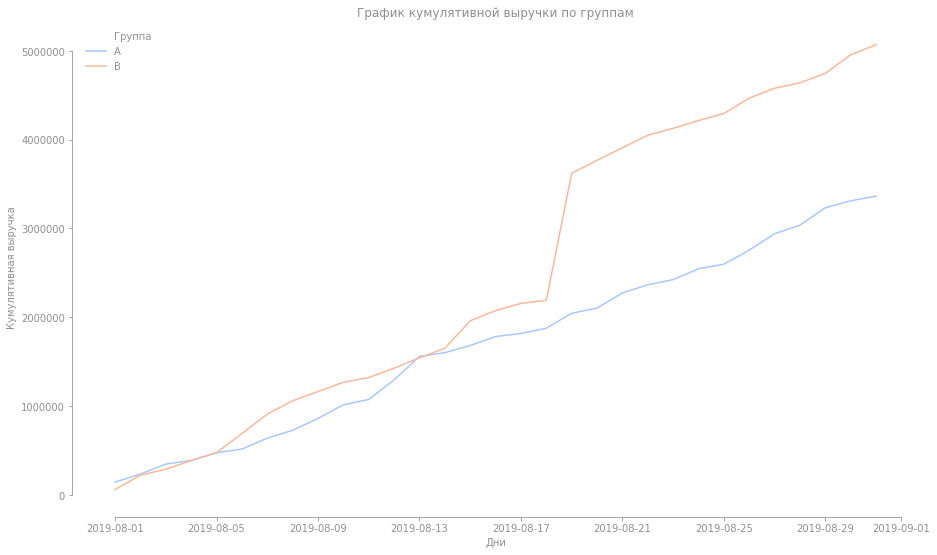

In [15]:
# строим график по группам
sns.lineplot(data=work_data, 
             x=work_data.index, # индекс с датами на ось X
             y='revenue_cumul', 
             hue='group', 
             palette='coolwarm'
            ).set(xlabel='Дни', 
                  ylabel='Кумулятивная выручка', 
                  title='График кумулятивной выручки по группам')
plt.legend(loc=2).texts[0].set_text('Группа') # заголовок и положение для легенды
sns.despine(trim=True, offset=5); # настройка отображения осей

In [16]:
work_data.query('date == ["2019-08-18", "2019-08-19", "2019-08-20"]')

,group,orders,buyers,revenue,visitors,orders_cumul,buyers_cumul,revenue_cumul,visitors_cumul,conversion
date,,,,,,,,,,
2019-08-18,A,13,13,59581,668,278,269,1876741,11127,0.024984
2019-08-18,B,7,7,35323,737,327,324,2190865,11171,0.029272
2019-08-19,A,21,21,168193,502,299,290,2044934,11629,0.025712
2019-08-19,B,21,20,1429920,487,348,344,3620785,11658,0.029851
2019-08-20,A,10,10,58679,575,309,300,2103613,12204,0.025320
2019-08-20,B,20,20,147274,560,368,364,3768059,12218,0.030119


In [17]:
orders.query('date == "2019-08-19"')['revenue'].agg(['min', 'median', 'max'])

min            50.0
median       2578.0
max       1294500.0
Name: revenue, dtype: float64

Выручка группы В практически сразу начала превышать выручку группы А; 19 августа накопленная выручка В резко выросла и отрыв с группой А увеличился ещё больше — к концу наблюдаемого периода группа В превышает группу А почти в 1,5 раза. Последние 10 дней обе группы стабилизировались.

Посколько группа В на протяжении всего месяца была стабильно выше группы А, у нас есть основания думать, что изменения на сайте приводят к росту выручки — позже проверим статистическую значимость этих различий. В то же время, резкий рост выручки в группе В 19 августа обеспечен одним заказом на сумму 1 294 500, это аномальное значение, поэтому мы не можем признать, что такая же разница в выручке будет сохраняться в других условиях.

<a id='302'></a>
### Кумулятивный средний чек по группам

Посчитаем накопленный средний чек как отношение накопленной выручки к накопленному числу заказов. Изобразим показатель каждой группы на графике:

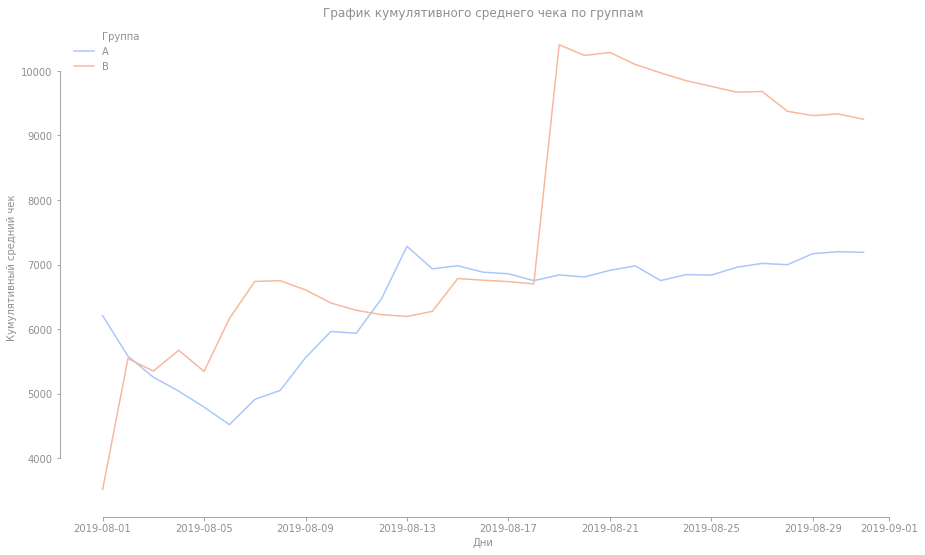

In [18]:
sns.lineplot(data=work_data, 
             x=work_data.index, 
             y=(work_data['revenue_cumul'] / work_data['orders_cumul']), 
             hue='group', 
             palette='coolwarm'
            ).set(xlabel='Дни', 
                  ylabel='Кумулятивный средний чек', 
                  title='График кумулятивного среднего чека по группам')
plt.legend(loc=2).texts[0].set_text('Группа')
sns.despine(trim=True, offset=5);

Здесь мы наблюдаем более разнообразную динамику для обеих групп — в некоторые дни средний чек группы А превышает показатели группы В. Резкие всплески или падения могут быть связаны с аномальным числом заказов или отдельными очень дорогими заказами — это мы снова видим 19 августа. В последние 10 дней динамика начинает стабилизироваться.

Посмотрим также на относительную динамику кумулятивного среднего чека — как росла или падала группа В относительно группы А:

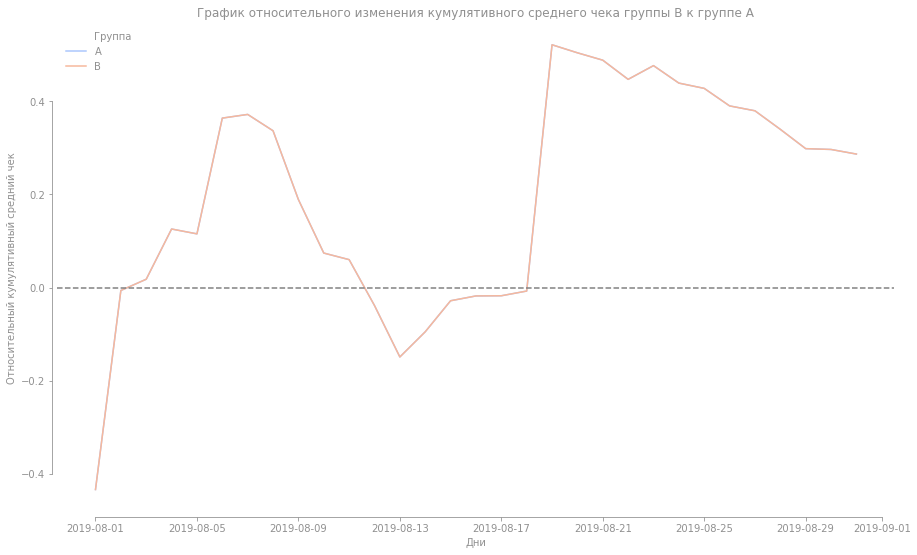

In [19]:
relative_aov = (
    (work_data.query('group == "B"')['revenue_cumul'] / work_data.query('group == "B"')['orders_cumul']) / 
    (work_data.query('group == "A"')['revenue_cumul'] / work_data.query('group == "A"')['orders_cumul']) - 1)

sns.lineplot(data=work_data, 
             x=work_data.index, 
             y=relative_aov, 
             hue='group', 
             palette='coolwarm'
            ).set(xlabel='Дни', 
                  ylabel='Относительный кумулятивный средний чек', 
                  title='График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.legend(loc=2).texts[0].set_text('Группа')
plt.axhline(y=0, color='grey', linestyle='--')
sns.despine(trim=True, offset=5);

Нулевая линия обозначает для нас уровень совпадения среднего чека В с А. Мы видим схожую динамику с предыдущим графиком — в большинстве случаев средний чек группы В превышает А, однако это разница нестабильна и в некоторые дни проваливается ниже нуля. К концу наблюдаемого периода есть тенденция к снижению стоимости среднего чека. 

Такие результаты пока плохо могут описать тенденцию к различиям между группами — возможно, стоит собрать ещё данных. В любом случае попробуем отфильтровать аномальные значения, а ещё нам нужно оценить статистическую значимость различий.

<a id='303'></a>
### Кумулятивная конверсия по группам

Ранее мы рассчитали конверсию как отношение накопленного количества заказов к накопленному количеству пользователей. Оценим различия между группами на графике:

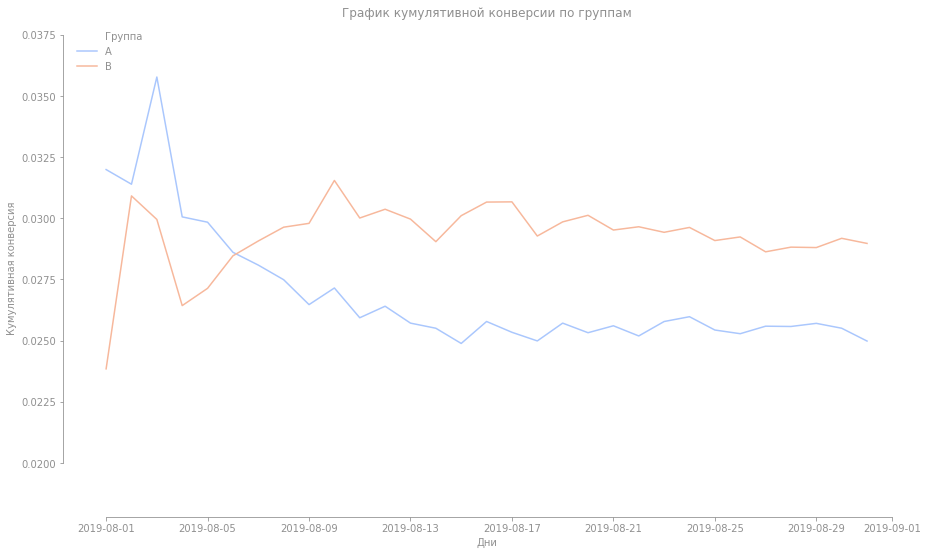

In [20]:
sns.lineplot(data=work_data, 
             x=work_data.index, 
             y='conversion', 
             hue='group', 
             palette='coolwarm'
            ).set(ylim=(0.018, 0.038), # масштаб оси Y
                  xlabel='Дни', 
                  ylabel='Кумулятивная конверсия', 
                  title='График кумулятивной конверсии по группам')
plt.legend(loc=2).texts[0].set_text('Группа')
sns.despine(trim=True, offset=5);

В начале периода заметны колебания показателей обеих групп, но после 10 августа они стабилизируются — конверсия у группы В стабильно выше, чем у А. Для подтверждения также проверим статистическую значимость различий.

Посмотрим конверсию группы В относительно А:

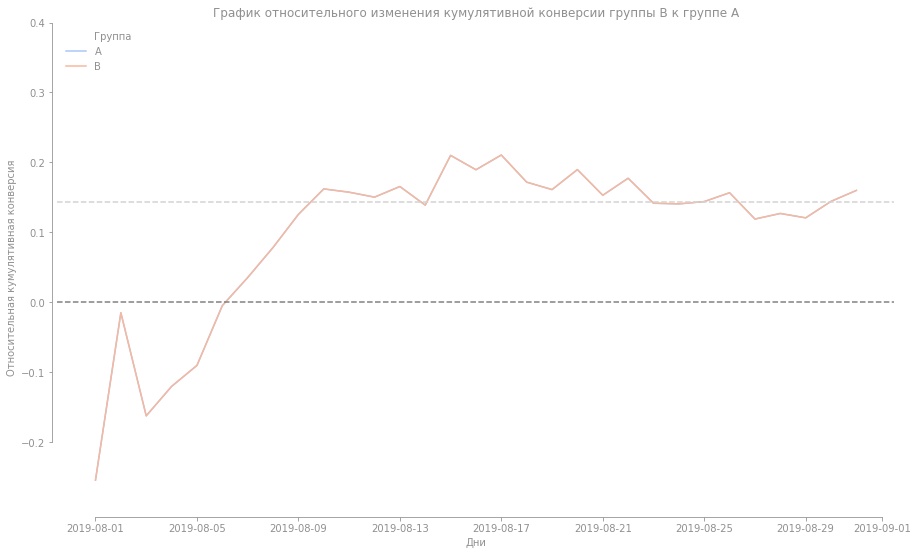

In [21]:
relative_conversion = (work_data.query('group == "B"')['conversion'] / 
                       work_data.query('group == "A"')['conversion'] - 1)

sns.lineplot(data=work_data, 
             x=work_data.index, 
             y=relative_conversion, 
             hue='group', 
             palette='coolwarm'
            ).set(ylim=(-0.3, 0.4), 
                  xlabel='Дни', 
                  ylabel='Относительная кумулятивная конверсия', 
                  title='График относительного изменения кумулятивной конверсии группы B к группе A')
plt.legend(loc=2).texts[0].set_text('Группа')
plt.axhline(y=0, color='grey', linestyle='--')
plt.axhline(y=relative_conversion.median(), color='lightgrey', linestyle='--')
sns.despine(trim=True, offset=5);

Также до 10 августа наблюдаются колебания в конверсии, а после группа В стабильно превышает группу А с разбросом от +1% до +2% — нестабилизированный показатель также может быть обусловлен аномалиями в данных. Стоит очистить данные от выбросов и оценить разницу в статистической значимости между «сырыми» и «очищенными» данными. 

<a id='304'></a>
### Граница для определения аномальных пользователей

На графиках мы замечали резкие всплески и падения в накопленных показателях. Это может говорить о наличии выбросов — в данном случае, о пользователях, которые сделали заметно больше заказов, чем остальные, или о заказах, которые стоили заметно дороже остальных. Диаграмма рассеяния позволит оценить, с какого уровня данные можно считать экстремальными.

0.90    1.0
0.95    1.0
0.99    2.0
Name: orders, dtype: float64

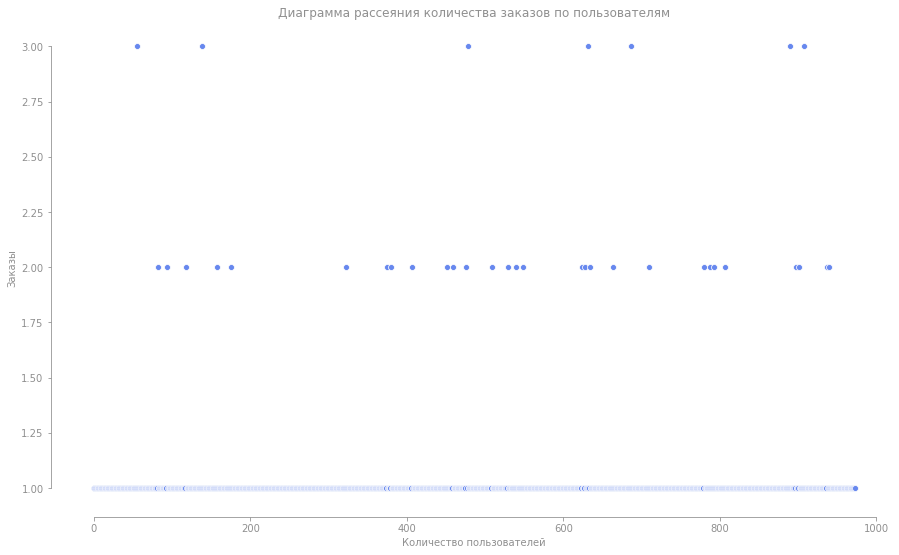

In [22]:
# подсчитаем количество заказов для каждого пользователя
orders_by_user = orders.groupby(['visitor_id', 'group']).agg(orders=('transaction_id', 'nunique')).reset_index()

# построим точечную диаграмму распределения количестве заказов
sns.scatterplot(data=orders_by_user['orders'])\
.set(xlabel='Количество пользователей', ylabel='Заказы', 
     title='Диаграмма рассеяния количества заказов по пользователям')
sns.despine(trim=True, offset=5)

# выведем значения квантилей
orders_by_user['orders'].quantile([.90, .95, .99])

Основное количество пользователей сделали по одному заказу, не более 1% — 2 заказа, а наибольшее количество — 3. Последних однозначно можно отсеять, мы потеряем меньше процента пользователей.

0.90    17990.0
0.95    26785.0
0.99    53904.0
Name: revenue, dtype: float64

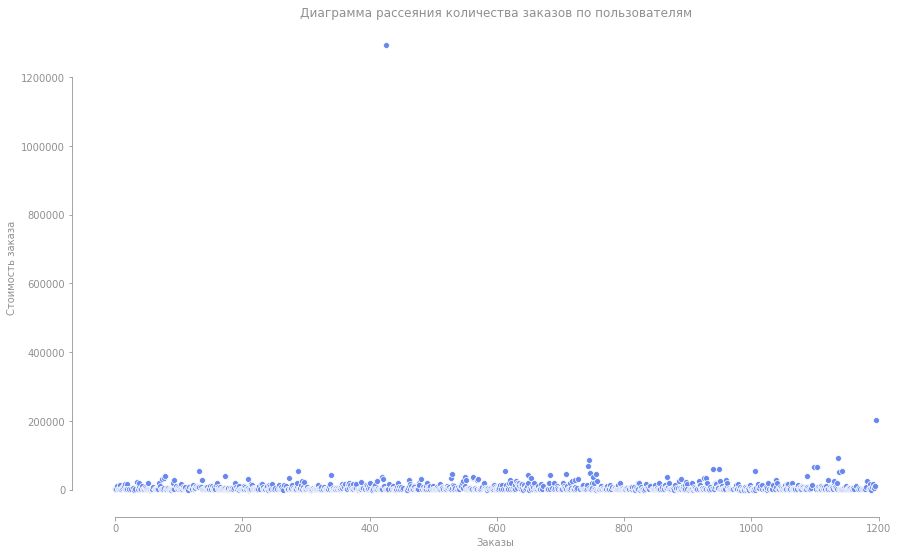

In [23]:
sns.scatterplot(data=orders['revenue'])\
.set(xlabel='Заказы', ylabel='Стоимость заказа', 
     title='Диаграмма рассеяния количества заказов по пользователям')
sns.despine(trim=True, offset=5)

orders['revenue'].quantile([.90, .95, .99])

Здесь заметен тот самый сверхдорогой заказ на 1,2 млн. за 19 августа. В данном случае есть смысл отфильтровать данные по 95-му процентилю, тогда мы потеряем не более 5% данных.

<a id='305'></a>
### Проверка статистической значимости различий между группами по «сырым» данным

Оценим статистическую значимость различий, которые были обнаружены на графиках — насколько мы им можем доверять. Попробуем сначала на исходных данных, а после сравним их с данными без выбросов. Если судить по диаграммам рассеяния выше, то данные не распределены нормально — поэтому выберем для проверки непараметрический критерий Манна-Уитни.

Сформируем выборки для статистического теста, где каждый элемент — число заказов определенного пользователя. Добавим к ним остальных пользователей, которые не сделали заказы, у них будет нулевое количество заказов. Таким образом, количество элементов в каждой выборке будет соответствовать количеству пользователей в каждой группе.
Для обеих выборок рассчитаем статистическую значимость различий по критерию Манна-Уитни и относительные изменения конверсии группы B к группе A. Так как конверсия — это отношение количества заказов к количеству пользователей, то для ее расчета будет достаточно взять среднее по выборке.

In [24]:
# сформируем выборки по группам
sample_a = orders_by_user.query('group == "A"')['orders'].append(
    pd.Series(0, index=np.arange(work_data.query('group == "A"')['visitors'].sum() - 
                                 len(orders_by_user.query('group == "A"')['orders']))))

sample_b = orders_by_user.query('group == "B"')['orders'].append(
    pd.Series(0, index=np.arange(work_data.query('group == "B"')['visitors'].sum() - 
                                 len(orders_by_user.query('group == "B"')['orders']))))


# проведем тест Манна-Уитни
alpha = .05 # пороговый уровень значимости
p_value = st.mannwhitneyu(sample_a, sample_b)[1] # тестовый уровень значимости — под индексом 1
print('Уровень значимости U-критерия Манна-Уитни: {:.5f}'.format(p_value))

if p_value < alpha:
    print('Можем отвергнуть нулевую гипотезу об отсутствии различий между группами.')
    print()
else:
    print('Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами.')
    print()

print('Различие в конверсии между группами по «сырым» данным: {:.2%}'.format(
    sample_b.mean() / sample_a.mean() - 1))

Уровень значимости U-критерия Манна-Уитни: 0.00551
Можем отвергнуть нулевую гипотезу об отсутствии различий между группами.

Различие в конверсии между группами по «сырым» данным: 15.98%


Уровень значимости меньше порогового уровня в 0,05, значит мы отвергаем нулевую гипотезу об отсутствии различий в конверсии и можем признать эти различия статистически значимыми: в группе В конверсия повысилась на 16%.

In [25]:
alpha = .05
p_value = st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1]
print('Уровень значимости U-критерия Манна-Уитни: {:.5f}'.format(p_value))

if p_value < alpha:
    print('Можем отвергнуть нулевую гипотезу об отсутствии различий между группами.')
    print()
else:
    print('Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами.')
    print()

print('Различие в среднем чеке между группами по «сырым» данным: {:.2%}'.format(
    orders.query('group == "B"')['revenue'].mean() / orders.query('group == "A"')['revenue'].mean() - 1))

Уровень значимости U-критерия Манна-Уитни: 0.41475
Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами.

Различие в среднем чеке между группами по «сырым» данным: 28.66%


Уровень значимости больше порогового уровня в 0,05, значит мы не можем отвергнуть нулевую гипотезу об отсутствии различий в среднем чеке — судить об этих различиях по существующим данным нельзя.

<a id='306'></a>
### Проверка статистической значимости различий между группами по «очищенным» данным

Повторим оценку различий конверсии и среднего чека по «очищенным» данным — это позволит судить о типичном поведении пользователей. Если результаты тестов подтвердятся, то мы в итоге признаем значимой разницу именно с этих данных. 

Сформируем для начала отдельный список пользователей с выбросами:

In [26]:
# таблица с 1% наиболее активных покупателей
orders_number_outliers = pd.concat(
    [orders_by_user.query('group == "A" and orders > @orders_by_user.orders.quantile(.99)')['visitor_id'], 
     orders_by_user.query('group == "B" and orders > @orders_by_user.orders.quantile(.99)')['visitor_id']])

# таблица с 5% наиболее дорогих заказов
orders_cost_outliers = orders[orders['revenue'] > orders['revenue'].quantile(.95)]['visitor_id']

# сбор аномальных пользователей
abnormal_users = pd.concat([orders_number_outliers, orders_cost_outliers]).drop_duplicates().sort_values()

Построим выборки для конверсий, не включая сюда пользователей с выбросами, и повторим процедуру выше:

In [27]:
# сформируем выборки по группам из отфильтрованных данных
sample_a_filtered = pd.concat(
    [orders_by_user.query('group == "A" and visitor_id not in @abnormal_users')['orders'], 
     pd.Series(0, index=np.arange(work_data.query('group == "A"')['visitors'].sum() - 
                                  len(orders_by_user.query('group == "A"')['orders'])))])

sample_b_filtered = pd.concat(
    [orders_by_user.query('group == "B" and visitor_id not in @abnormal_users')['orders'], 
     pd.Series(0, index=np.arange(work_data.query('group == "B"')['visitors'].sum() - 
                                  len(orders_by_user.query('group == "B"')['orders'])))])


# проведем тест Манна-Уитни
alpha = .05
p_value = st.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]
print('Уровень значимости U-критерия Манна-Уитни: {:.5f}'.format(p_value))

if p_value < alpha:
    print('Можем отвергнуть нулевую гипотезу об отсутствии различий между группами.')
    print()
else:
    print('Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами.')
    print()

print('Различия в конверсии между группами по «очищенным» данным: {:.2%}'
      .format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

Уровень значимости U-критерия Манна-Уитни: 0.00618
Можем отвергнуть нулевую гипотезу об отсутствии различий между группами.

Различия в конверсии между группами по «очищенным» данным: 18.19%


Уровень значимости меньше порогового уровня в 0,05, значит мы отвергаем нулевую гипотезу об отсутствии различий в конверсии и можем признать эти различия статистически значимыми. По данным без аномалий в группе В конверсия повысилась на 18,2%.

In [28]:
alpha = .05
p_value = st.mannwhitneyu(orders.query('group == "A" and visitor_id not in @abnormal_users')['revenue'], 
                          orders.query('group == "B" and visitor_id not in @abnormal_users')['revenue'])[1]
print('Уровень значимости U-критерия Манна-Уитни: {:.5f}'.format(p_value))

if p_value < alpha:
    print('Можем отвергнуть нулевую гипотезу об отсутствии различий между группами.')
    print()
else:
    print('Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами.')
    print()

print('Различия в среднем чеке между группами по «очищенным» данным: {:.2%}'
      .format(orders.query('group == "B" and visitor_id not in @abnormal_users')['revenue'].mean() / 
              orders.query('group == "A" and visitor_id not in @abnormal_users')['revenue'].mean() - 1))

Уровень значимости U-критерия Манна-Уитни: 0.32295
Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами.

Различия в среднем чеке между группами по «очищенным» данным: -4.85%


Уровень значимости больше порогового уровня в 0,05, значит мы не можем отвергнуть нулевую гипотезу об отсутствии различий в среднем чеке — с высокой долей вероятности эти различия получены случайно.

<a id='307'></a>
### Выводы из анализа A/B-теста

По итогам теста были получены данные за месяц об активности, количестве заказов и выручке с пользователей, разделенных на две группы. Обнаружили, что тест прошел не идеально — 58 пользователей оказались в обеих группах, и данные о них пришлось удалить из анализа, и даже после этого в группах оказалось неодинаковое количество покупателей. Важно предотвратить эти проблемы в будущих тестах. Также в данных были аномалии — несколько очень крупных заказов и пользователи, которые заказывали чаще остальных. Эти данные мы отфильровали, чтобы можно было судить о типичном поведении пользователей.
   
Исходя из обнаруженных фактов, мы можем заключить следующее:
1. Есть статистически значимые различия в **конверсии** — на новой версии сайта она выросла на **18,2%** (по отфильтрованным от аномалий данным). Динамика кумулятивной конверсии показывает, что показатели в обеих группах стабилизировались — следовательно, существующих данных достаточно, чтобы сделать вывод о результатах эксперимента.
2. Статистически значимых различий в **среднем чеке** не обнаружено, полученная разница с высокой вероятностью была получена случайно — поэтому на данный момент никаких выводов здесь сделать нельзя. Похоже, что изучаемые нами в ходе A/B-теста изменения на сайте не влияют на средний чек.

Таким образом, мы можем остановить тест и признать, что изменения на сайте обеспечивают существенный рост конверсии пользователей в покупателей.